## MNIST Classification Medium article



https://towardsdatascience.com/handwritten-digit-mnist-pytorch-977b5338e627

In [33]:
import torch 
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import torch.nn.functional as F
import matplotlib.pylab as plt
import numpy as np
from torch.utils.data import Dataset
from time import time

In [3]:
def show_data(data_sample):
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.show()

In [4]:
NUM_EPOCHS = 15
LEARNING_RATE = 1e-3
BATCH_SIZE = 64

transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),])

In [5]:
trainset = dsets.MNIST(root='./../data', 
                            train=True, 
                            download=True, 
                            transform=transform)
valset = dsets.MNIST(root='./../data', 
                            train=True, 
                            download=True, 
                            transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size=BATCH_SIZE, 
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valset, 
                                        batch_size=BATCH_SIZE, 
                                        shuffle=True)

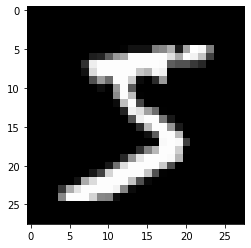

In [6]:
show_data(trainset[0])

In [13]:
input_size = 784
hidden_sizes = [128, 64]
output_size = 10

model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], output_size),
                      )
print(model)
#apperently, logsoftmax() and NLLLOss() together act as cross entropy

Sequential(
  (0): Linear(in_features=784, out_features=128, bias=True)
  (1): ReLU()
  (2): Linear(in_features=128, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=10, bias=True)
)


In [14]:
criterion = nn.CrossEntropyLoss()
images, labels = next(iter(trainloader))
images = images.view(images.shape[0], -1)

logps = model(images) #log probabilities

In [15]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.003, momentum=0.9)
time0 = time()
for e in range(NUM_EPOCHS):
    running_loss = 0
    for images, labels in trainloader:
        # Flatten MNIST images into a 784 long vector
        images = images.view(images.shape[0], -1)
    
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    else:#else loop runs if the for loop completes without breaking
        print("Epoch {} - Training loss: {}".format(e, running_loss/len(trainloader)))

print("\nTraining Time (in minutes) =",(time()-time0)/60)

Epoch 0 - Training loss: 0.6527008114021216
Epoch 1 - Training loss: 0.2838090661365086
Epoch 2 - Training loss: 0.21581495445229607
Epoch 3 - Training loss: 0.17379428201646946
Epoch 4 - Training loss: 0.14331757380907087
Epoch 5 - Training loss: 0.1217623344316745
Epoch 6 - Training loss: 0.10827710040842992
Epoch 7 - Training loss: 0.0953321840667696
Epoch 8 - Training loss: 0.08525975176127258
Epoch 9 - Training loss: 0.077580030918169
Epoch 10 - Training loss: 0.07021821720420376
Epoch 11 - Training loss: 0.064145264423776
Epoch 12 - Training loss: 0.05924724820685555
Epoch 13 - Training loss: 0.05355434836710551
Epoch 14 - Training loss: 0.05065008656912124

Training Time (in minutes) = 2.3305697162946064


In [44]:
with torch.no_grad():
    ps = model(trainset[0][0].view(-1,784))
print(ps)
probab = list(ps.numpy()[0])
print(probab)
pred_label = probab.index(max(probab))
print(pred_label)

tensor([[ -0.0943,  -0.7896,   0.8942,  11.0459, -15.4160,  14.5020,  -6.5997,
          -3.6873,  -2.4163,  -4.3063]])
[-0.09427034, -0.7896271, 0.89421344, 11.045858, -15.416041, 14.501959, -6.599713, -3.6872563, -2.4162529, -4.306346]
5


In [28]:
correct_count, all_count = 0, 0
for images,labels in valloader:
  for i in range(len(labels)):
    img = images[i].view(1, 784)
    with torch.no_grad():# nograd cuz dont need to backprop and its faster
        ps = model(img)

    #print(logps)
    probab = list(ps.numpy()[0])
    pred_label = probab.index(max(probab))
    true_label = labels.numpy()[i]
    if(true_label == pred_label):
      correct_count += 1
    all_count += 1

print("Number Of Images Tested =", all_count)
print("\nModel Accuracy =", (correct_count/all_count))

Number Of Images Tested = 60000

Model Accuracy = 0.9867333333333334


In [29]:
def get_same_index(target, label):
    label_indices = []

    for i in range(len(target)):
        if target[i] == label:
            label_indices.append(i)

    return label_indices

In [178]:
def comparisonDataConsecutive(dataSet):
    indices = []
    #gets all the indices of the data obsv with same y from the dataset that is passed in
    for i in range(5):
        indlist = get_same_index(dataSet.targets, i)
        indices.append(indlist)
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    comp = []
    for indi in range(len(indices) - 1):
        comp.append(int(min(len(subsets[indi]), len(subsets[indi + 1]))))
    tot1 = sum(comp)
    x = torch.zeros([tot1, 2, 28, 28], dtype=torch.float32)
    y = torch.zeros([tot1,1,1])
    # 1 for first pic greater, 0 for first pic less
    k = 0
    for i in range(len(subsets) - 1):
        for j in range(int(comp[i] / 2)):
            x[k][0] = subsets[i][j][0]
            x[k][1] = subsets[i + 1][j][0]
            y[k][0][0] = 0
            k += 1
        for j in range(int(comp[i] / 2), comp[i]):
            x[k][1] = subsets[i][j][0]
            x[k][0] = subsets[i + 1][j][0]
            y[k][0][0] = 1
            k += 1
    return x,y

In [197]:
def comparisonDataNonconsecutive(dataSet):
    indices = []
    # gets all the indices of the data obsv with same y from the dataset that is passed in
    for i in range(5):
        indlist = get_same_index(dataSet.targets, i)
        indices.append(indlist)
    subsets = []
    [subsets.append(torch.utils.data.Subset(dataSet, i)) for i in indices]
    comp = {}
    for i in range(len(subsets) - 2):
        for j in range(i + 2, len(subsets), 1):
            comp[(i, j)] = int(min(len(subsets[i]), len(subsets[j])))
    tot = sum(comp.values())
    x = torch.zeros([tot, 2, 28, 28], dtype=torch.float32)
    y = torch.zeros([tot, 1,1])
    k = 0
    for key, values in comp.items():
        for value in range(int(values / 2)):
            x[k][0] = subsets[key[0]][value][0]
            x[k][1] = subsets[key[1]][value][0]
            y[k][0][0] = 0
            k += 1
        for value in range(int(values / 2), values):
            x[k][0] = subsets[key[1]][value][0]
            x[k][1] = subsets[key[0]][value][0]
            y[k][0][0] = 1
            k += 1
    return x,y


In [180]:
class Trainsetcomp(Dataset):
    def __init__(self, x, y):
        self.len = (x.shape[0])
        self.x = x
        self.y = y

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return self.len

In [198]:
x, y = comparisonDataConsecutive(trainset)
traindataComp = Trainsetcomp(x,y)
x,y = comparisonDataConsecutive(valset)
valdataComp = Trainsetcomp(x,y)

In [199]:
trainloader = torch.utils.data.DataLoader(traindataComp,
                                          batch_size=64,
                                          shuffle=True)
valloader = torch.utils.data.DataLoader(valdataComp,
                                          batch_size=64,
                                          shuffle=True)
x,y = comparisonDataNonconsecutive(valset)
testdata = Trainsetcomp(x,y)
testloader = torch.utils.data.DataLoader(testdata,
                                          batch_size=64,
                                          shuffle=True)

In [183]:
class Model1(nn.Module):
    def __init__(self,ind,h1,outd):
        super(Model1, self).__init__()
        self.lin1 = nn.Linear(ind,h1)
        self.lin2 = nn.Linear(h1,outd)
        
    
    def forward(self,x):
        x = torch.relu(self.lin1(x))
        x = torch.sigmoid(self.lin2(x))
        return x

In [184]:
def classification(x):
    #print(x.shape)
    a = x.shape
    ret = torch.zeros(a[0],1,2)
    for i in range(a[0]):
        with torch.no_grad():
            img1 = x[i][0]
            
            #print(img1.shape)
            img2 = x[i][1]
            #print(img2.shape)
            img1 = model(img1.view(-1,784))
            img2 = model(img2.view(-1,784))
            
        probab = list(img1.numpy()[0])
        img1num = probab.index(max(probab))
        probab = list(img2.numpy()[0])
        img2num = probab.index(max(probab))
        img1num = float(img1num)
        img2num = float(img2num)
        ret[i][0][0] = img1num
        ret[i][0][1] = img2num
        #print('hi')
    return ret

In [185]:
'''model1 = Model1(2,4,1)
x = classification(traindataComp[0][0])
model1(x)'''

'model1 = Model1(2,4,1)\nx = classification(traindataComp[0][0])\nmodel1(x)'

In [188]:
def train(model, criterion, optimizer,trainloader, epochs = 30):
    lossList = []
    #time0 = time()
    for i in range(epochs):
        runningLoss = 0
        for x, y in trainloader:
            optimizer.zero_grad()
            #print(x.shape)
            x = classification(x)
            #print(x.shape)
            yhat = model(x)
            #print(yhat.shape)
            #print(y.shape)
            
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            runningLoss += loss.item()
        
        print('epoch ', i, ' loss: ', str(runningLoss / len(traindataComp)))
        lossList.append(runningLoss / len(traindataComp))

In [191]:
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01)
lossL = train(model1,criterion,optimizer,trainloader)

epoch  0  loss:  0.0021273696022785817
epoch  1  loss:  0.002111932837476005
epoch  2  loss:  0.0020991200204038985
epoch  3  loss:  0.0020877820280398285
epoch  4  loss:  0.002077905876828406
epoch  5  loss:  0.0020671507761626145
epoch  6  loss:  0.0020571333600683164
epoch  7  loss:  0.0020475195652204063
epoch  8  loss:  0.0020379912046674165
epoch  9  loss:  0.002028400887527183
epoch  10  loss:  0.002018856323412592
epoch  11  loss:  0.0020108728440577785
epoch  12  loss:  0.002001665906675371
epoch  13  loss:  0.0019917093185478018
epoch  14  loss:  0.0019840959419900766
epoch  15  loss:  0.001974325971285801
epoch  16  loss:  0.0019646633641192527
epoch  17  loss:  0.0019638496650275354
epoch  18  loss:  0.0019705039073651892
epoch  19  loss:  0.001961947652317373
epoch  20  loss:  0.0019520618157798483
epoch  21  loss:  0.0019434972270841201
epoch  22  loss:  0.0019338271843798742
epoch  23  loss:  0.001925386769474396
epoch  24  loss:  0.001916536011594956
epoch  25  loss:  0

In [195]:
totcount = 0
correctcount = 0
for x,y in valloader:
    x = classification(x)
    with torch.no_grad():
        yhat = model1(x)
    #print(yhat.shape)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.9, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.1, z, yhat)
    for i,j in zip(yhat,y):
        if i[0] == j[0]:
            correctcount+=1
        totcount+=1
print(correctcount)
print(totcount)
#print(len(dataPairing.valdataComp))
print('valset accuracy: ', correctcount/totcount)

3921
4004
valset accuracy:  0.9792707292707292


In [204]:
def show_dataComp(data_sample,y):
    plt.subplot(1,2,1)
    plt.imshow(data_sample[0].numpy().reshape(28, 28), cmap='gray')
    plt.subplot(1,2,2)
    plt.imshow(data_sample[1].numpy().reshape(28, 28), cmap='gray')
    plt.title('y = ' + str(y))

    plt.show()

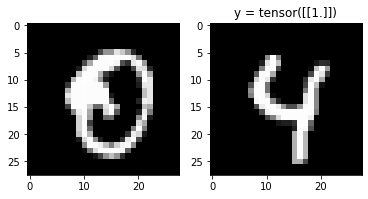

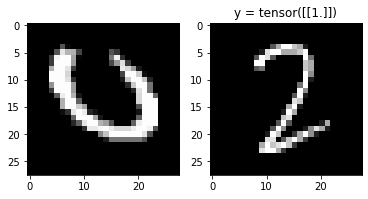

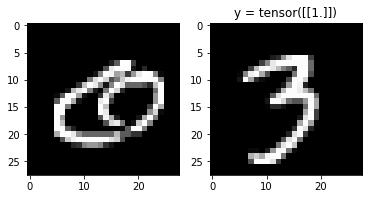

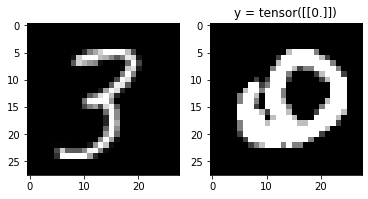

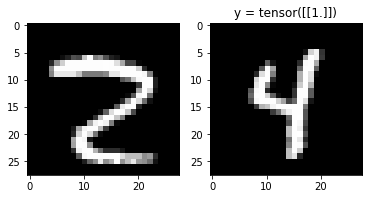

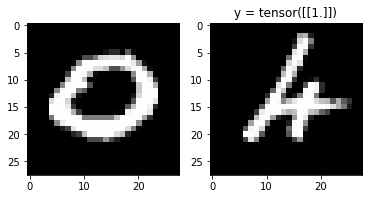

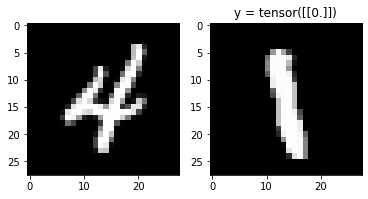

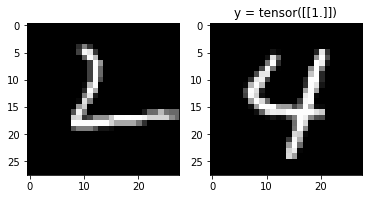

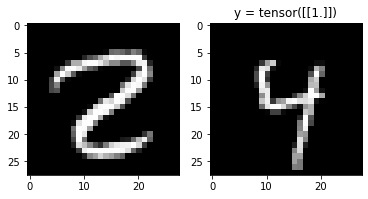

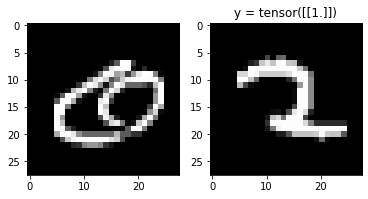

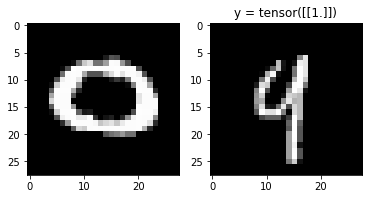

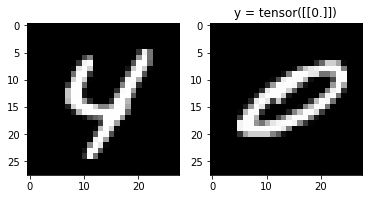

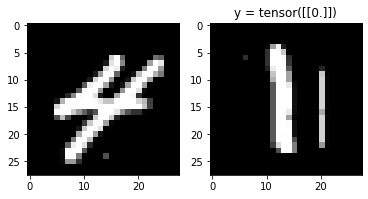

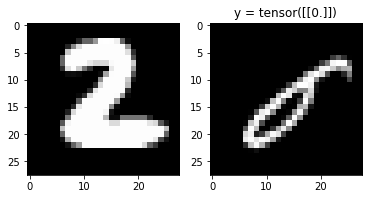

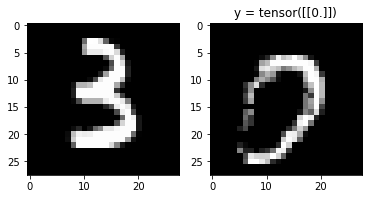

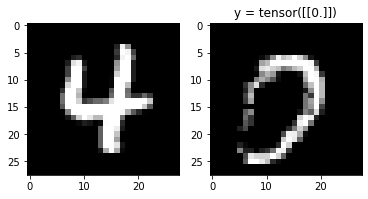

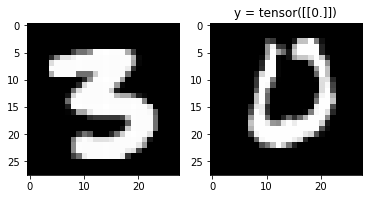

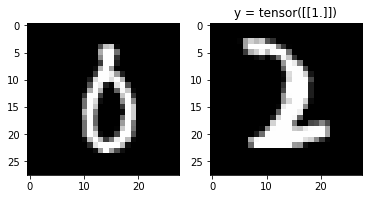

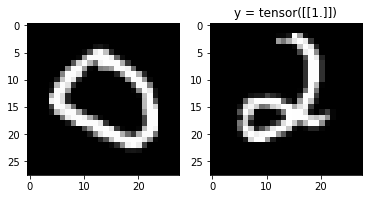

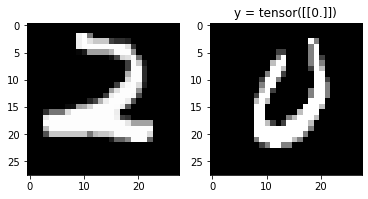

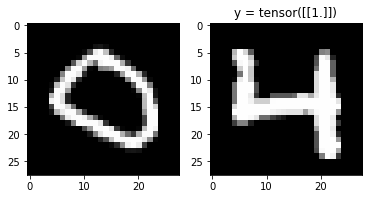

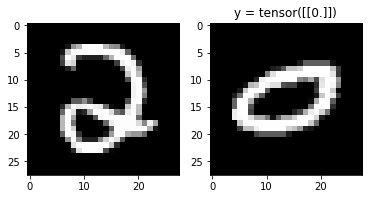

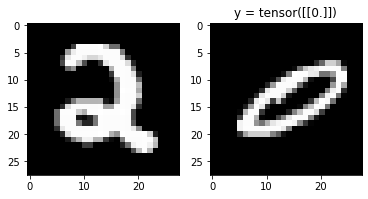

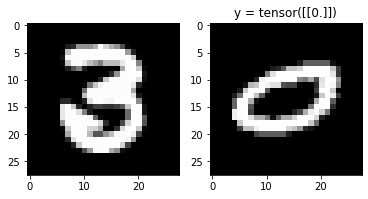

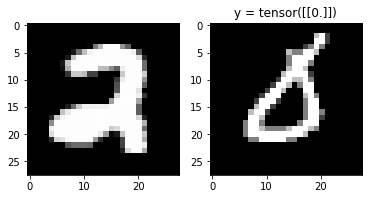

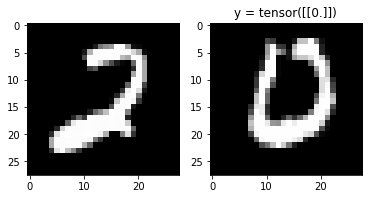

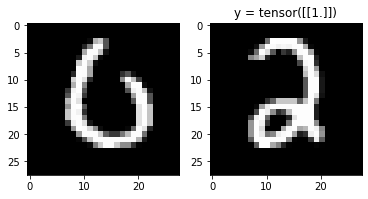

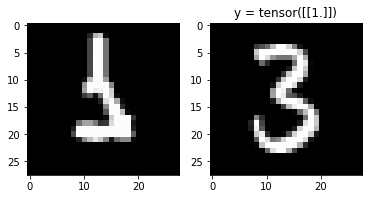

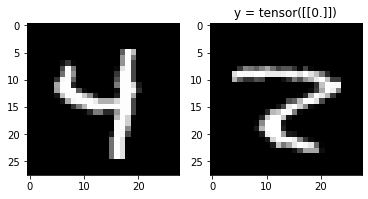

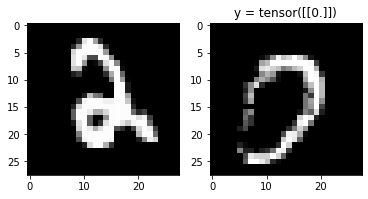

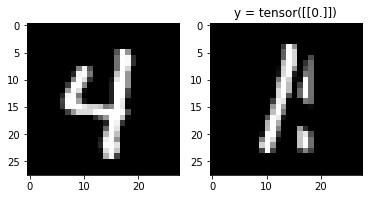

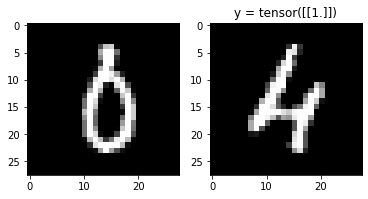

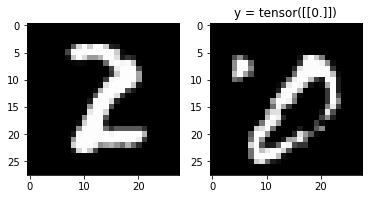

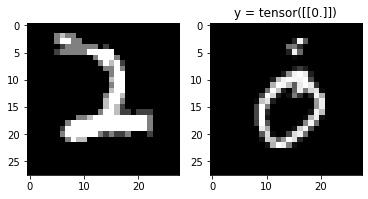

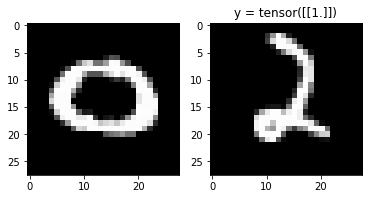

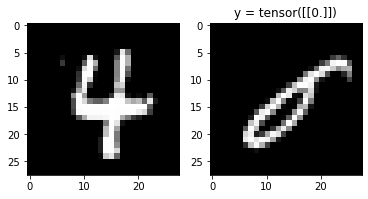

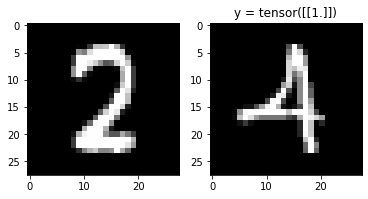

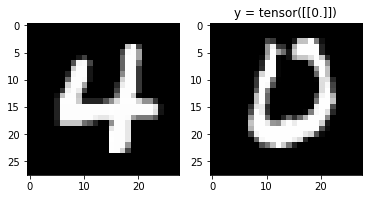

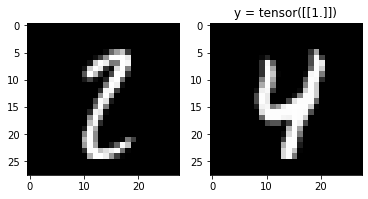

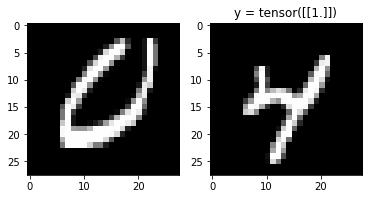

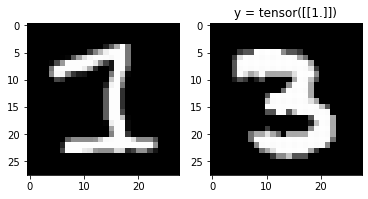

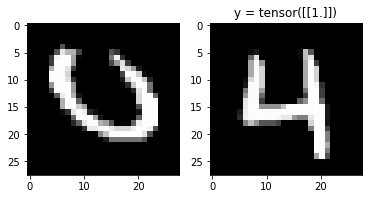

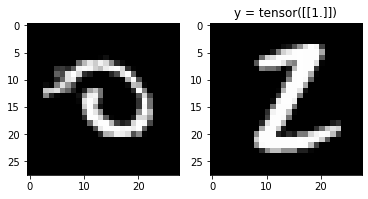

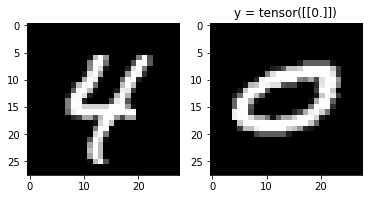

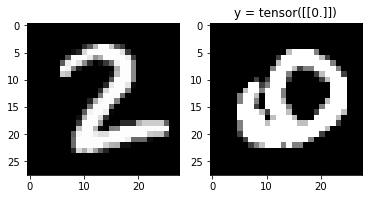

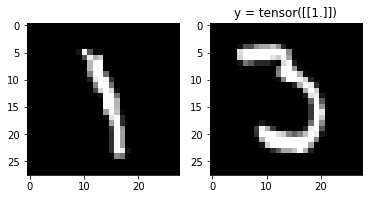

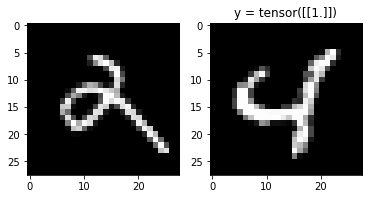

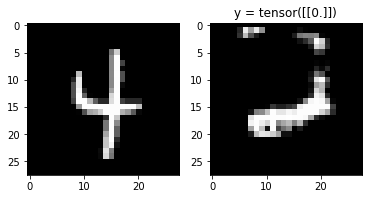

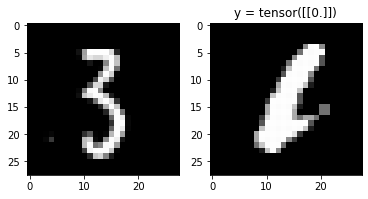

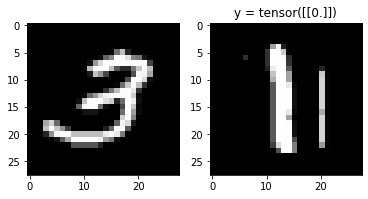

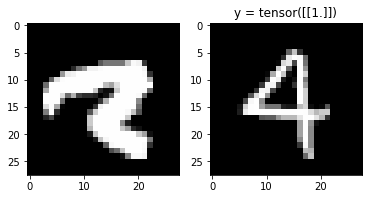

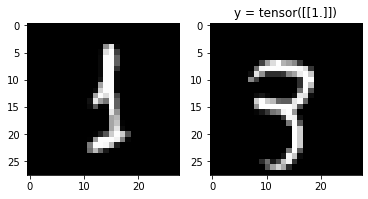

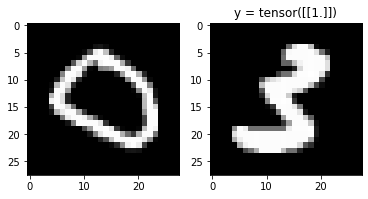

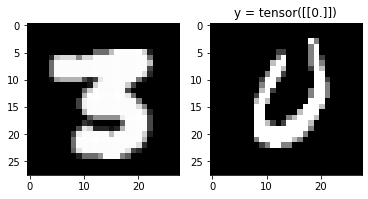

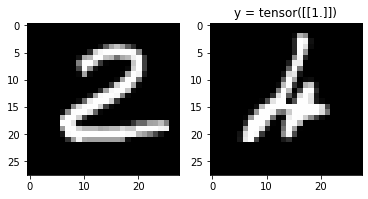

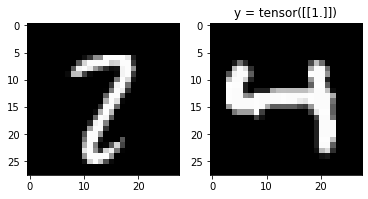

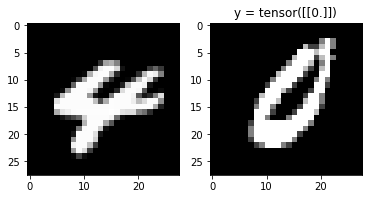

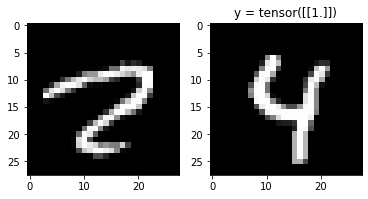

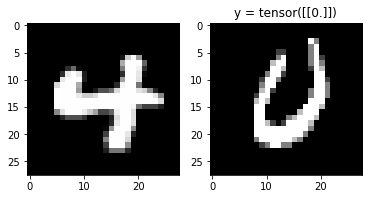

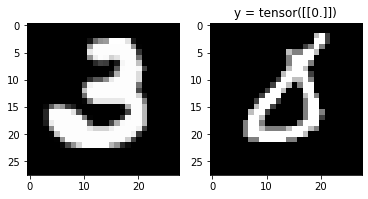

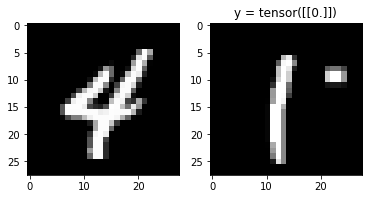

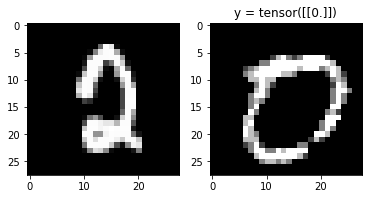

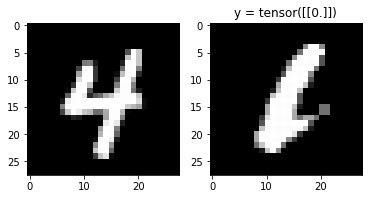

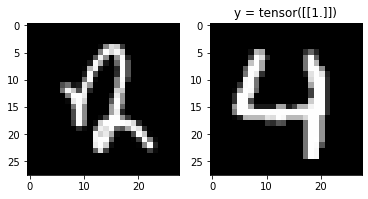

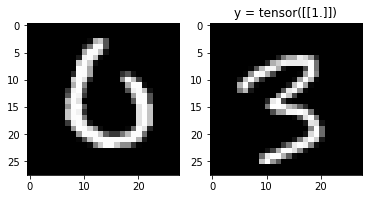

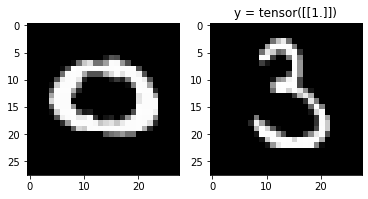

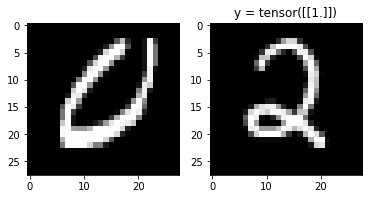

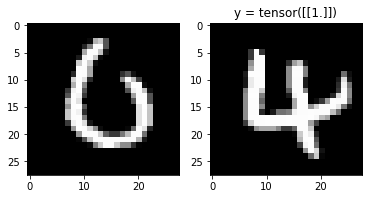

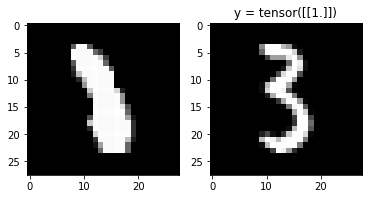

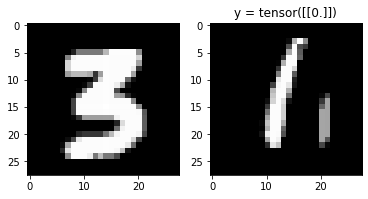

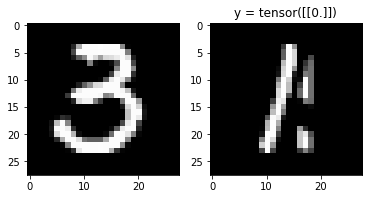

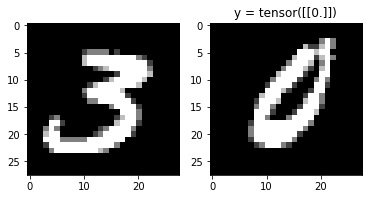

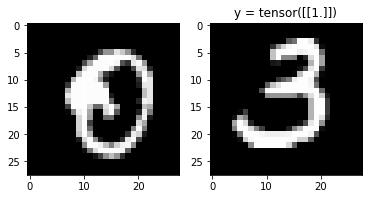

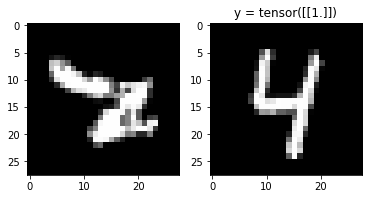

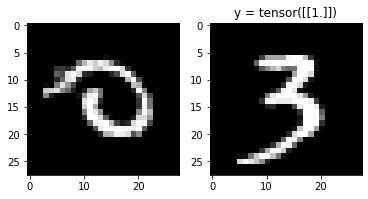

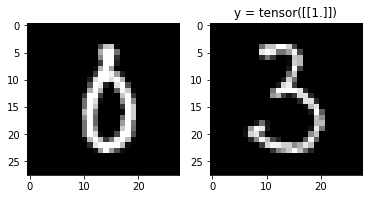

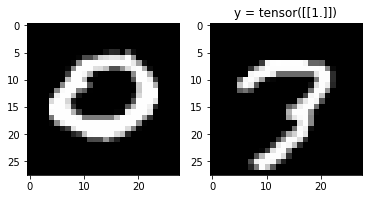

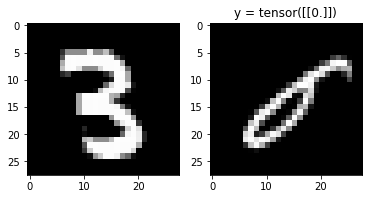

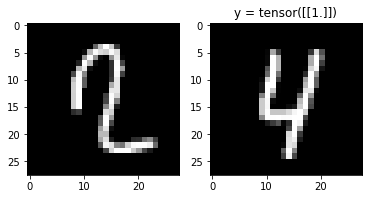

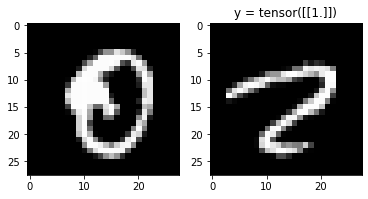

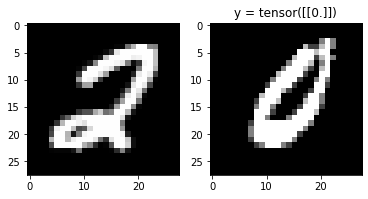

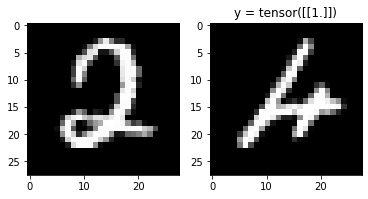

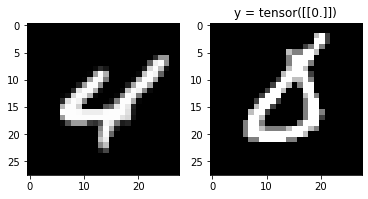

15598
15871
test set accuracy:  0.982798815449562


In [205]:
## non consecutive test set
for x,y in testloader:
    x1 = classification(x)
    with torch.no_grad():
        yhat = model1(x1)
    ones = torch.ones(yhat.shape)
    yhat = torch.where(yhat>.5, ones, yhat)
    z = torch.zeros(yhat.shape)
    yhat = torch.where(yhat<0.5, z, yhat)
    wrongC = 0
    for i in range(len(y)):
        #print(i)
        if yhat[i][0] == y[i][0]:
            correctcount+=1
            #p = torch.reshape(x[i], (2,28,28))
            #show_dataComp(p, y[i])
            
        else:
            if wrongC < 2:
                p = torch.reshape(x[i], (2,28,28))
                show_dataComp(p, yhat[i])
            wrongC += 1
        totcount+=1
print(correctcount)
print(totcount)
print('test set accuracy: ', correctcount/totcount)